# ML-model initialisation and execution

In this notebook, we will show how CoPro creates, trains, and tests a machine-learning model.

## Preparations

Start with loading the required packages.

In [1]:
from copro import utils, pipeline, evaluation, plots, machine_learning

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.7b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


To be able to also run this notebooks, some of the previously saved data needs to be loaded.

In [3]:
conflict_gdf = gpd.read_file('conflicts.shp')
selected_polygons_gdf = gpd.read_file('polygons.shp')

In [4]:
global_arr = np.load('global_df.npy', allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

### The configurations-file (cfg-file)

To be able to continue the simulation with the same settings as in the previous notebook, the cfg-file has to be read again and the model needs to be initialised subsequently.

In [5]:
settings_file = 'example_settings.cfg'

In [6]:
config, out_dir, root_dir = utils.initiate_setup(settings_file)


#### CoPro version 0.0.7b ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2020): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: verbose mode on: True
INFO: saving output to folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT
DEBUG: remove files in folder C:\Users\hoch0001\Documents\_code\copro\example\OUT
DEBUG: sparing XY.npy
DEBUG: remove files in folder C:\Users\hoch0001\Documents\_code\copro\example\OUT\clfs


### Loading the XY-data

Since no XY-data is specified in the config-file initially, we have to set this manually. Note that this de-tour is only necessary due to the splitting of the workflow in different notebooks!

In [7]:
config.set('pre_calc', 'XY', str(os.path.join(os.path.abspath(config.get('general', 'output_dir')), 'XY.npy')))

To double-check, see if this file actually exists.

In [8]:
os.path.isfile(config.get('pre_calc', 'XY'))

True

The scence is set now and we can create the X-array and Y-array from file.

In [9]:
X, Y = pipeline.create_XY(config, out_dir, root_dir, selected_polygons_gdf, conflict_gdf)

INFO: loading XY data from file C:\Users\hoch0001\Documents\_code\copro\example\OUT\XY.npy
DEBUG: number of data points including missing values: 4110
DEBUG: number of data points excluding missing values: 4005
DEBUG: a fraction of 16.05 percent in the data corresponds to conflicts.


## Scaler and classifier

### Background

In principle, one can put all kind of data into the samples matrix X, leading to a wide spread of magnitudes, units, statistics etc. It is therefore needed to scale (or transform) the data in the X-array such that sensible comparisons and computations are possible. To that end, a scaling technique is applied.

Once there is a scaled X-array, a machine-learning model can be fitted with it together with the target values Y. 

### Implementation

CoPro supports four different scaling techniques. For more info, see the [scikit-learn documentation](https://scikit-learn.org/stable/getting_started.html#transformers-and-pre-processors).

1. MinMaxScaler;
2. StandardScaler;
3. RobustScaler;
4. QuantileTransformer.

From the wide range of machine-learning model, CoPro employs three different ones from the categorie of [supervised learning](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

1. NuSVC;
1. KNeighborsClassifier;
1. RFClassifier.

Note that CoPro uses pretty much the default parameterization of the scalers and models. An extensive [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) did not show any significant improvements when changing the parameters.

In [10]:
scaler, clf = pipeline.prepare_ML(config)

DEBUG: chosen scaling method is QuantileTransformer(random_state=42)
DEBUG: chosen ML model is RandomForestClassifier(class_weight={1: 100}, n_estimators=1000,
                       random_state=42)


As scaling technique, it is used:

In [11]:
scaler

QuantileTransformer(random_state=42)

And as classifier, it was chosen for:

In [12]:
clf

RandomForestClassifier(class_weight={1: 100}, n_estimators=1000,
                       random_state=42)

## Output initialization

Since the model is run multiple times, we need to initialize a few lists first to append the output per run.

In [13]:
out_X_df = evaluation.init_out_df()
out_y_df = evaluation.init_out_df()

In [14]:
out_dict = evaluation.init_out_dict()

In [15]:
trps, aucs, mean_fpr = evaluation.init_out_ROC_curve()

## ML-model execution

The pudels kern! This is where the magic happens, and not only once. To make sure that any conincidental results are ruled out, we run the model multiple times. Thereby, always different parts of the XY-array are used for training and prediction. By using a sufficient number of runs and averaging the overall results, we should be able to get a good picture of what the model is capable of.

Per repetition, the model is evaluated. The main evaluation metric is the mean ROC-score and [**ROC-curve**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html), plotted at the end of all runs. Additional evaluation metrics are computed as described below.

Also, CoPro keeps track of polygon-IDs and geometry througout this process. This is possible by keeping them associated to the actual samples matrix (X) for the entire simulation process besides the two times where they need to be separated: the training and test moment. As this is a very technical process, we here refer to the [API](https://copro.readthedocs.io/en/latest/api/XYdata.html) description of CoPro

INFO: run 1 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.894
... Precision: 0.729
... Recall: 0.513
... F1 score: 0.602
... Brier loss score: 0.084
... Cohen-Kappa score: 0.543
... ROC AUC score 0.871
No handles with labels found to put in legend.


INFO: run 2 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.889
... Precision: 0.702
... Recall: 0.546
... F1 score: 0.614
... Brier loss score: 0.086
... Cohen-Kappa score: 0.551
... ROC AUC score 0.872
No handles with labels found to put in legend.


INFO: run 3 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.878
... Precision: 0.690
... Recall: 0.446
... F1 score: 0.542
... Brier loss score: 0.096
... Cohen-Kappa score: 0.475
... ROC AUC score 0.845
No handles with labels found to put in legend.


INFO: run 4 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.890
... Precision: 0.750
... Recall: 0.548
... F1 score: 0.633
... Brier loss score: 0.088
... Cohen-Kappa score: 0.571
... ROC AUC score 0.870
No handles with labels found to put in legend.


INFO: run 5 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.889
... Precision: 0.746
... Recall: 0.512
... F1 score: 0.608
... Brier loss score: 0.088
... Cohen-Kappa score: 0.546
... ROC AUC score 0.871
No handles with labels found to put in legend.


INFO: run 6 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.896
... Precision: 0.802
... Recall: 0.464
... F1 score: 0.587
... Brier loss score: 0.085
... Cohen-Kappa score: 0.533
... ROC AUC score 0.862
No handles with labels found to put in legend.


INFO: run 7 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.894
... Precision: 0.695
... Recall: 0.474
... F1 score: 0.564
... Brier loss score: 0.081
... Cohen-Kappa score: 0.506
... ROC AUC score 0.871
No handles with labels found to put in legend.


INFO: run 8 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.898
... Precision: 0.739
... Recall: 0.540
... F1 score: 0.624
... Brier loss score: 0.077
... Cohen-Kappa score: 0.566
... ROC AUC score 0.897
No handles with labels found to put in legend.


INFO: run 9 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.895
... Precision: 0.758
... Recall: 0.505
... F1 score: 0.606
... Brier loss score: 0.086
... Cohen-Kappa score: 0.549
... ROC AUC score 0.864
No handles with labels found to put in legend.


INFO: run 10 of 10
INFO: using all data
DEBUG: fitting and transforming X
DEBUG: splitting both X and Y in train and test data
DEBUG: dumping classifier to C:\Users\hoch0001\Documents\_code\copro\example\./OUT\clfs


... Accuracy: 0.889
... Precision: 0.748
... Recall: 0.522
... F1 score: 0.615
... Brier loss score: 0.088
... Cohen-Kappa score: 0.552
... ROC AUC score 0.877
No handles with labels found to put in legend.


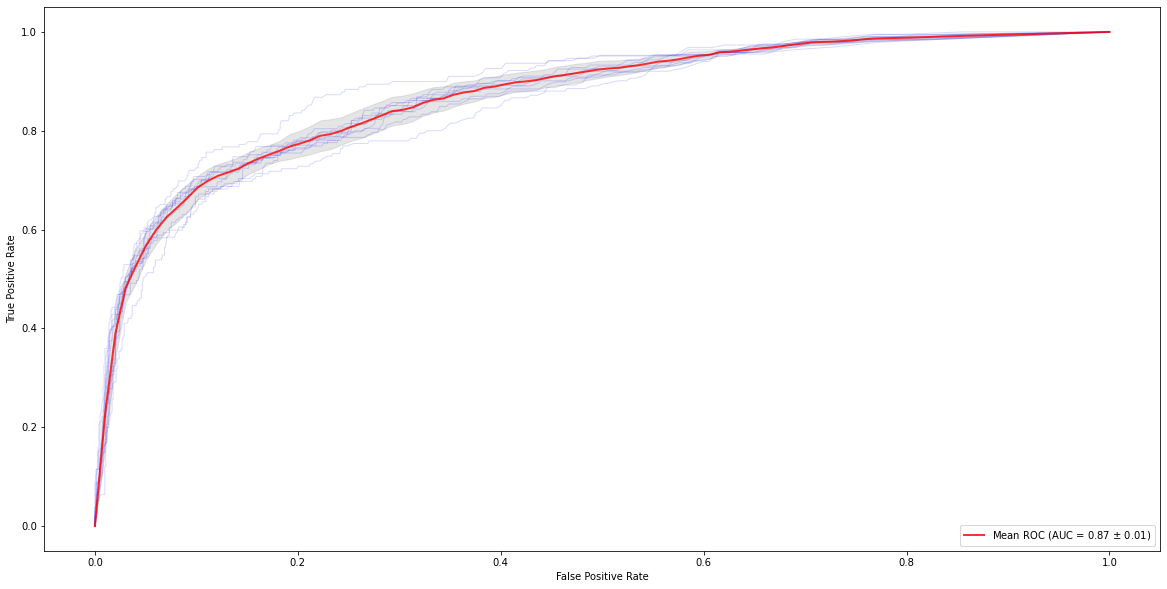

In [16]:
# #- create plot instance
fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

#- go through all n model executions
for n in range(config.getint('settings', 'n_runs')):
    
    print('INFO: run {} of {}'.format(n+1, config.getint('settings', 'n_runs')))

    #- run machine learning model and return outputs
    X_df, y_df, eval_dict = pipeline.run_reference(X, Y, config, scaler, clf, out_dir, run_nr=n+1)
    
    #- select sub-dataset with only datapoints with observed conflicts
    X1_df, y1_df = utils.get_conflict_datapoints_only(X_df, y_df)
    
    #- append per model execution
    out_X_df = evaluation.fill_out_df(out_X_df, X_df)
    out_y_df = evaluation.fill_out_df(out_y_df, y_df)
    out_dict = evaluation.fill_out_dict(out_dict, eval_dict)

    #- plot ROC curve per model execution
    tprs, aucs = plots.plot_ROC_curve_n_times(ax1, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

#- plot mean ROC curve
plots.plot_ROC_curve_n_mean(ax1, tprs, aucs, mean_fpr)

plt.savefig('../docs/_static/roc_curve.png', dpi=300, bbox_inches='tight')

## Model evaluation

### For all data points

During the model runs, the computed model evaluation scores per model execution were stored to a dictionary. Currently, the evaluation scores used are:

* [**Accuracy**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): the fraction of correct predictions;
* [**Precision**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative;
* [**Recall**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples;
* [**F1 score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): the F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0;
* [**Cohen-Kappa score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html): is used to measure inter-rater reliability. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.
* [**Brier score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html): the smaller the Brier score, the better, hence the naming with “loss”. The lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier loss score is relatively sensitive for imbalanced datasets;
* [**ROC score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): a value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas a value of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. A value of 0.0 suggests perfectly incorrect predictions. Note that the ROC score is relatively insensitive for imbalanced datasets.

Let's check the mean scores over all runs:

In [17]:
for key in out_dict:
    
    print('average {0} of run with {1} repetitions is {2:0.3f}'.format(key, config.getint('settings', 'n_runs'), np.mean(out_dict[key])))

average Accuracy of run with 10 repetitions is 0.891
average Precision of run with 10 repetitions is 0.736
average Recall of run with 10 repetitions is 0.507
average F1 score of run with 10 repetitions is 0.600
average Cohen-Kappa score of run with 10 repetitions is 0.539
average Brier loss score of run with 10 repetitions is 0.086
average ROC AUC score of run with 10 repetitions is 0.870


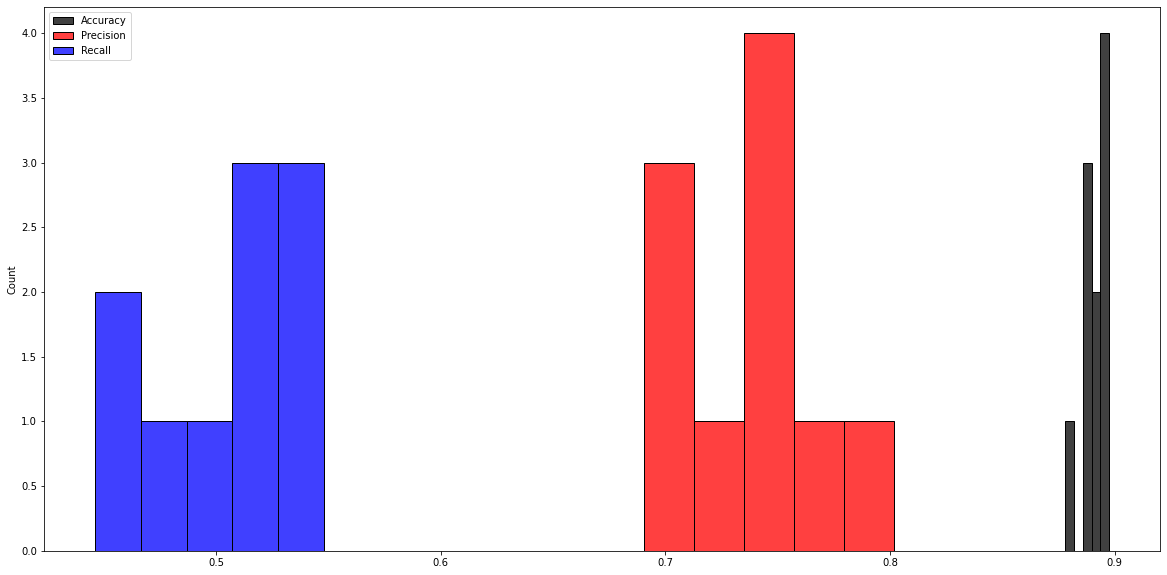

In [18]:
plots.metrics_distribution(out_dict, figsize=(20, 10));

Based on all data points, the [**confusion matrix**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) can be plotted. This is a relatively straightforward way to visualize how good the classifier values are predicted by the model.

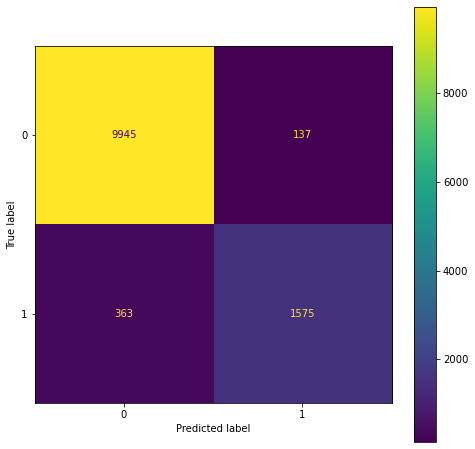

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
metrics.plot_confusion_matrix(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax);

### Per unique polygon

Thus far, we merely looked at numerical scores. This of course tells us a lot about the quality of the machine-learning model and its predictions, but not so much about how this looks like spatially. We therefore combine the observations and predictions made with the associated polygons based on a 'global' dataframe functioning as a look-up table. By this means, each model output can be connected to its polygon using a unique ID.

In [20]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(out_y_df, global_df, out_dir=None)

First, let's have a look at how often each polygon occurs in the all test samples, i.e. those obtained by appending the test samples per model execution. Besides, the overall relative distribution is visualized.

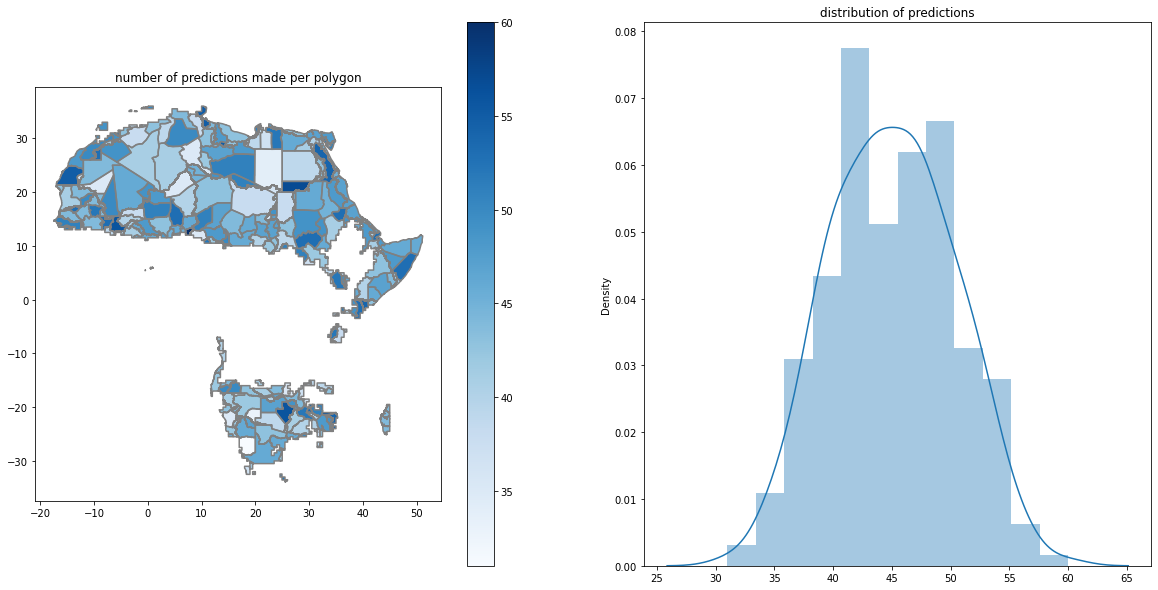

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='nr_predictions', legend=True, cmap='Blues')
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit.nr_predictions.values, ax=ax2)
ax2.set_title('distribution of predictions');

By repeating the model n times, the aim is to represent all polygons in the resulting test sample. The fraction is computed below. 

Note that is should be close to 100 % but may be slightly less. This can happen if input variables have no data for one polygon, leading to a removal of those polygons from the analysis. Or because some polygons and input data may not overlap.

In [22]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(selected_polygons_gdf)*100))

97.45 % of all active polygons are considered in test sample


By aggregating results per polygon, we can now assess model output spatially. Three main aspects are presented here:

1. The chance of a correct prediction, defined as the ratio of number of correct predictions made to overall number of predictions made;
2. The total number of conflicts in the test data;
3. The chance of conflict, defined as the ration of number of conflict predictions to overall number of predictions made.

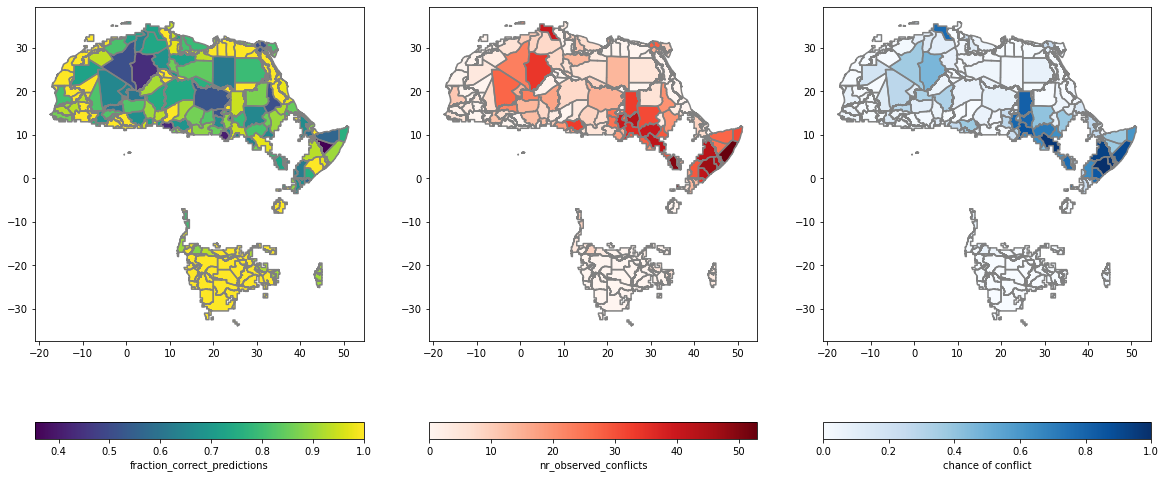

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='fraction_correct_predictions', legend=True, 
             legend_kwds={'label': "fraction_correct_predictions", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
gdf_hit.plot(ax=ax2, column='nr_observed_conflicts', legend=True, cmap='Reds', 
             legend_kwds={'label': "nr_observed_conflicts", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax2, color='0.5')
gdf_hit.plot(ax=ax3, column='chance_of_conflict', legend=True, cmap='Blues', vmin=0, vmax=1, 
             legend_kwds={'label': "chance of conflict", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax3, color='0.5');

## Preparing for the future

In this notebook, we have trained and tested our model with various combinations of data. Subsequently, the average performance of the model was evaluated with a range of metrics.

If we want to re-use our model for the future and want to make projections, it is necessary to save the model (that is, the fitted classifier). It can then be loaded and one or more projections can be made with other variable values than those used for this reference run.

To that end, the classifier is fitted again, but then with all data, i.e. without a split-sample test. That way, the classifier fit is most robust.

In [24]:
clf = machine_learning.pickle_clf(scaler, clf, config, root_dir)

INFO: fitting the classifier with all data from reference period
DEBUG: loading XY data from C:\Users\hoch0001\Documents\_code\copro\example\OUT\XY.npy
DEBUG: number of data points including missing values: 4110
DEBUG: number of data points excluding missing values: 4005
DEBUG: a fraction of 16.05 percent in the data corresponds to conflicts.


### Feature importances

With this fitted classifier, we can also determine the relative feature importance of each feature. This helps getting an idea which factor is the strongest predictor of conflict risk.

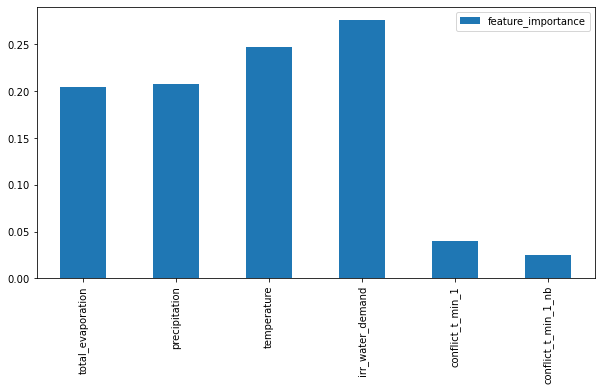

In [25]:
plots.factor_importance(clf, config, out_dir, figsize=(10, 5));